# CHF Prediction with XGBoost using Short-Term HRV Signals

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import xgboost

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, \
                            recall_score, f1_score, fbeta_score, classification_report, \
                            roc_auc_score, \
                            ConfusionMatrixDisplay, RocCurveDisplay

import datetime
import os
import pprint

In [3]:
def classification_report_heatmap(cr, label_names, model_name):
    corr_matrix = []

    for label in label_names:
        if cr[label]:
            row = [cr[label]['precision'], cr[label]['recall'], cr[label]['f1-score']]
            corr_matrix.append(row)

    sns.heatmap(
        pd.DataFrame(np.array(corr_matrix), index=label_names, columns=['precision', 'recall', 'f1-score']),
        annot=True,
        cmap='Blues',
        vmin=0,
        vmax=1
    )

    plt.title("Classification Report Heatmap\nModel: {0}".format(model_name))
    plt.tight_layout()
    plt.show()

## Load Dataset

In [4]:
import pathlib

par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
pathlib.Path(par_dir).parent.absolute()

WindowsPath('c:/Users/BIOINFO 9/Documents/Rino/HRV')

In [5]:
PROJECT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
# PROJECT_DIR = pathlib.Path(par_dir).parent.absolute()
# PROJECT_DIR = "/content/drive/MyDrive/Projects/HRV"
DATA_DIR = os.path.join(PROJECT_DIR, "dataset/short-term")

In [6]:
MINS_DIR = "5-min-2-hours-0.5-overlap-normal-beat-with-ectopic-info"
df_nsrdb = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_nsrdb.xlsx"))
df_chfdb = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_chfdb.xlsx"))
df_nsr2db = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_nsr2db.xlsx"))
df_chf2db = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_chf2db.xlsx"))
df = pd.concat(
    [
        df_nsr2db,
        df_chf2db,
    ],
    axis=0
).reset_index(drop=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3888 entries, 0 to 3887
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3888 non-null   object 
 1   start_secs              3888 non-null   int64  
 2   end_secs                3888 non-null   int64  
 3   db_source               3888 non-null   object 
 4   age                     3888 non-null   float64
 5   gender                  3888 non-null   object 
 6   fs                      3888 non-null   int64  
 7   signal_length           0 non-null      float64
 8   recording_time_hours    0 non-null      float64
 9   recording_time_seconds  0 non-null      float64
 10  normal_beats            3888 non-null   int64  
 11  abnormal_beats          3888 non-null   int64  
 12  normal_beats_ratio      3888 non-null   float64
 13  rri_length              3888 non-null   int64  
 14  nni_length              3888 non-null   

## Data Cleaning & Filtering

In [8]:
df_loaded = df.copy()

In [9]:
map_gender = {"m": 1, "f": 0}

# df = df.dropna()
df = df_loaded.copy()
df = df[(df.age != "?") & (df.gender != "?")]
df = df.replace(["?"], np.nan)
df['age'] = np.array(df['age'], dtype=np.float16)
df['gender'] = df['gender'].map(lambda x: map_gender[x.lower()])
df["record_ids"] = df["id"].map(lambda x: "-".join(x.split("-")[:2]))
df = df[["id", "record_ids"] + df.drop(columns=["id", "record_ids"]).columns.to_list()]
df = df.drop(columns=['tinn'])
df = df.replace([np.inf, -np.inf], np.nan)
# df = df[df['age'] >= 10] # useless since no data with age > 10 in CHFDB, CHF2DB, NSRDB, NSR2DB
df = df[df["normal_beats_ratio"] >= 0.9]

if 'db_source' in df.columns:
    db_source = df['db_source']
    df = df.drop(columns=['db_source'])
drop_columns = ["signal_length", "recording_time_hours", "recording_time_seconds"]
df = df.drop(columns=drop_columns)

df = df.dropna()
df["ratio_sd1_sd2"] = 1 / df["ratio_sd2_sd1"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2945 entries, 0 to 3030
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  2945 non-null   object 
 1   record_ids          2945 non-null   object 
 2   start_secs          2945 non-null   int64  
 3   end_secs            2945 non-null   int64  
 4   age                 2945 non-null   float16
 5   gender              2945 non-null   int64  
 6   fs                  2945 non-null   int64  
 7   normal_beats        2945 non-null   int64  
 8   abnormal_beats      2945 non-null   int64  
 9   normal_beats_ratio  2945 non-null   float64
 10  rri_length          2945 non-null   int64  
 11  nni_length          2945 non-null   int64  
 12  mean_nni            2945 non-null   float64
 13  sdnn                2945 non-null   float64
 14  sdsd                2945 non-null   float64
 15  nni_50              2945 non-null   int64  
 16  pnni_5

In [10]:
db_source.value_counts()

nsr2db    2517
chf2db     428
Name: db_source, dtype: int64

## Train-Test Split

In [11]:
train_record_ids = pd.read_csv(os.path.join(PROJECT_DIR, "dataset", "train_record_ids_7-3_post-filter.csv"))
test_record_ids = pd.read_csv(os.path.join(PROJECT_DIR, "dataset", "test_record_ids_7-3_post-filter.csv"))

df_train = df[
    df["record_ids"].isin(train_record_ids["id"].values)
]

df_test = df[
    df["record_ids"].isin(test_record_ids["id"].values)
]

print(df_train.shape)
print(df_test.shape)

df_train.sample(3)

(2269, 46)
(676, 46)


,id,record_ids,start_secs,end_secs,age,gender,fs,normal_beats,abnormal_beats,normal_beats_ratio,...,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk,ratio_sd1_sd2
1121,nsr2db-nsr024-4800-5100,nsr2db-nsr024,4800,5100,63.0,0,128,399,33,0.923611,...,48.080837,74.418243,1.547773,1.547773,4.757771,460.730321,1.361009,Sinus,0,0.646089
1332,nsr2db-nsr029-1800-2100,nsr2db-nsr029,1800,2100,63.0,1,128,483,0,1.000000,...,10.176829,48.394215,4.755334,4.755334,3.896526,920.522546,1.682719,Sinus,0,0.210290
2634,chf2db-chf202-4950-5250,chf2db-chf202,4950,5250,59.0,0,128,456,0,1.000000,...,11.930813,27.634764,2.316252,2.316252,3.722246,256.036263,1.861415,NYHA class: III,1,0.431732


In [12]:
df_inspect = df_test.copy()

In [13]:
data_info = ['age', 'gender', 'db_source']
time_domain_indices = ['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr']
freq_domain_indices = ['lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu', 'total_power', 'vlf']
geometrical_indices = ['triangular_index']
poincare_plot_indices = ['sd1', 'sd2', 'ratio_sd1_sd2']
csi_csv_indices = ['csi', 'cvi', 'Modified_csi']
sampen = ['sampen']
disease_info = ['cardiac_info', 'risk']

## Feature Selection

In [14]:
columns_needed = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices + \
                 geometrical_indices + \
                 sampen + \
                 ['risk']

df_train = df_train[columns_needed]
df_test = df_test[columns_needed]

X_train = df_train.drop(columns=['risk'])
y_train = df_train['risk']
X_test = df_test.drop(columns=['risk'])
y_test = df_test['risk']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2269, 33) (2269,)
(676, 33) (676,)


In [15]:
print(y_train.value_counts())
print(y_test.value_counts())

0    1910
1     359
Name: risk, dtype: int64
0    607
1     69
Name: risk, dtype: int64


In [16]:
pd.set_option('display.max_columns', None)
df_train.sample(3)

,age,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi,triangular_index,sampen,risk
2645,59.0,0,651.841639,29.630962,30.337154,5,1.091703,113,24.672489,30.340151,656.250,511.71875,0.046545,0.045457,92.346742,189.629630,72.452830,6.979135,111.315409,161.695900,0.688424,40.773186,59.226814,375.500890,102.489581,21.475064,35.983461,0.596804,1.675593,4.092157,241.174495,4.935484,1.851009,1
1513,65.0,1,980.755208,75.274818,25.729796,13,4.347826,114,38.127090,25.734585,984.375,328.12500,0.026240,0.076752,61.537741,71.775701,51.543624,4.721363,724.056166,78.811442,9.187196,90.183756,9.816244,2732.430444,1929.562837,18.224214,104.883146,0.173757,5.755153,4.485474,2414.474350,17.647059,1.213682,0
1402,70.0,0,716.689149,70.347947,35.366371,4,0.961538,87,20.913462,35.366376,734.375,496.09375,0.049347,0.098157,84.812616,185.060241,73.142857,11.960208,192.088199,235.200606,0.816699,44.955121,55.044879,723.084558,295.795752,25.037912,96.284839,0.260040,3.845562,4.586276,1481.077185,10.170732,0.675462,0


In [17]:
pd.reset_option('display.max_columns')

In [18]:
LABEL_NAMES = ["Healthy", "CHF"]

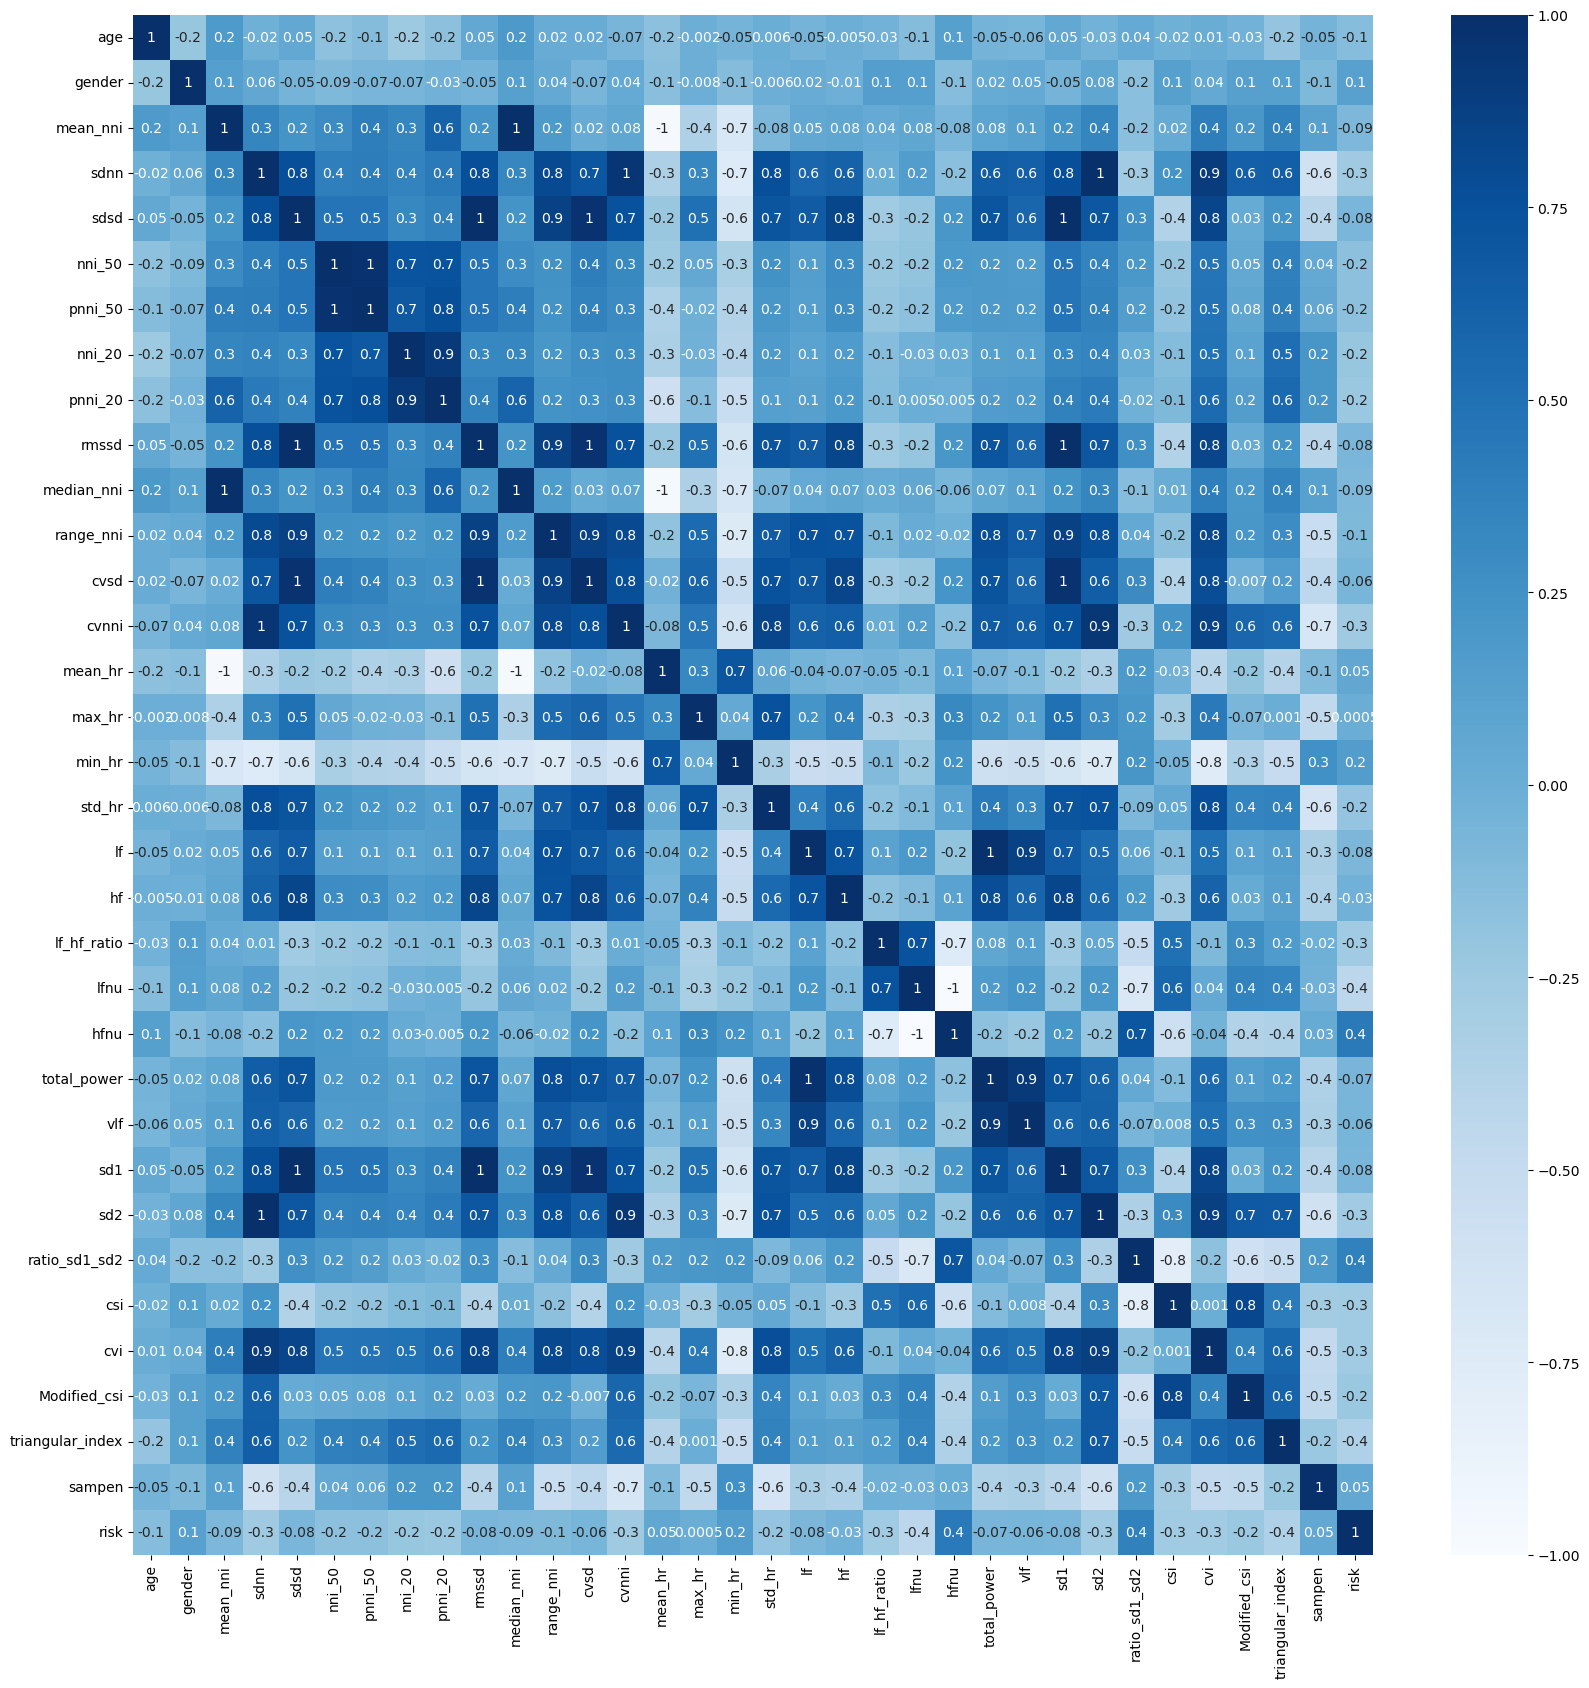

In [19]:
plt.rcParams['figure.figsize'] = (20, 20)
heatmap = sns.heatmap(df_train.corr(), annot=True, cmap="Blues", fmt='.1g')
plt.rcdefaults()
plt.show()

## XGBoost

In [20]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut

from sklearn.metrics import make_scorer

In [21]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

In [22]:
# A parameter grid for XGBoost
params = {
    'learning_rate': [0.2, 0.3, 0.4],
    'n_estimators': [50, 75, 100, 125, 150, 175, 200],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 5, 10],
    'gamma': [1, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

In [23]:
gs = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="accuracy"
)

In [24]:
start = datetime.datetime.now()
gs.fit(X_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 33)
Fitting time: 0 hours, 7 minutes, 0 seconds, 736193 microseconds


## Evaluation

In [25]:
gs.score(X_test, y_test)

0.9334319526627219

TRAIN SET RESULTS
TN, FP, FN, TP       : 1910 0 0 359
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      1910
         CHF       1.00      1.00      1.00       359

    accuracy                           1.00      2269
   macro avg       1.00      1.00      1.00      2269
weighted avg       1.00      1.00      1.00      2269




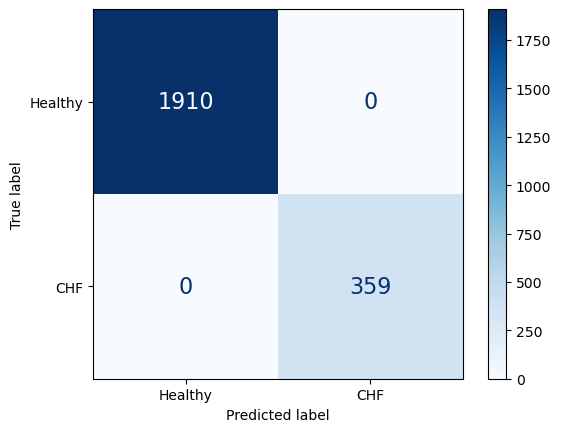


TEST SET RESULTS
TN, FP, FN, TP       : 581 26 19 50
Accuracy             : 0.9334319526627219
Precision            : 0.9366465535139624
Sensitivity          : 0.7246376811594203
Specificity          : 0.957166392092257
F1-Score             : 0.9348457368066677
AUC Score            : 0.8409020366258386
              precision    recall  f1-score   support

     Healthy       0.97      0.96      0.96       607
         CHF       0.66      0.72      0.69        69

    accuracy                           0.93       676
   macro avg       0.81      0.84      0.83       676
weighted avg       0.94      0.93      0.93       676




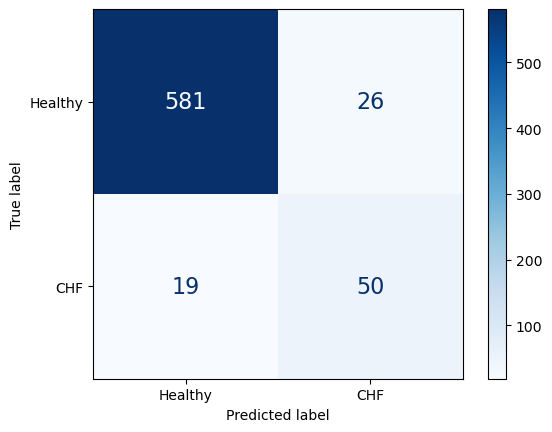

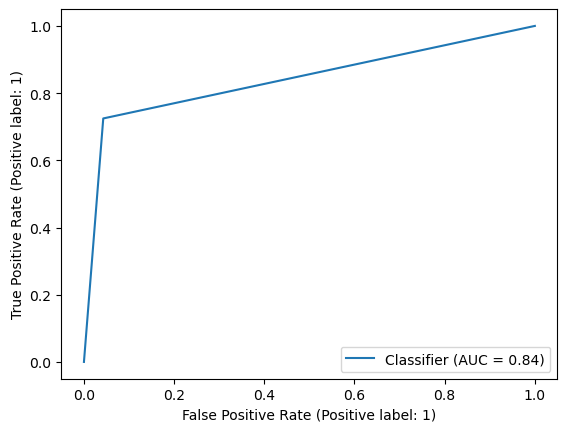

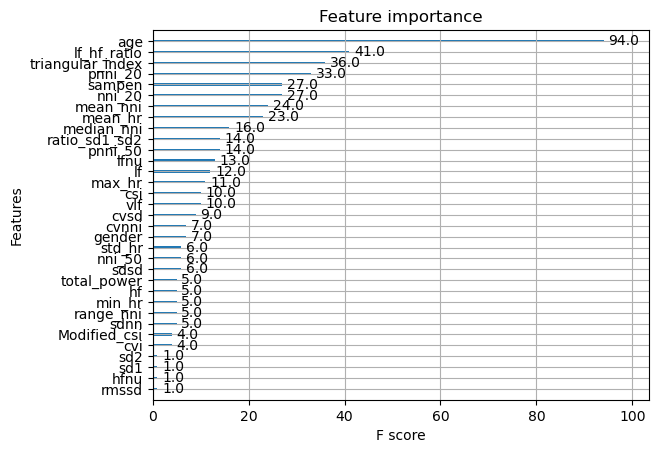

In [26]:
y_pred_train = gs.best_estimator_.predict(X_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs.best_estimator_.predict(X_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs.best_estimator_)
plt.show()

In [27]:
print("Best Params")
pprint.pprint(gs.best_params_)
print()

Best Params
{'colsample_bytree': 0.6,
 'gamma': 1,
 'learning_rate': 0.2,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 150,
 'subsample': 0.8}



### Sensitivity

In [28]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall",
)

In [29]:
start = datetime.datetime.now()
gs_sensitivity.fit(X_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 33)
Fitting time: 0 hours, 7 minutes, 3 seconds, 497143 microseconds


In [30]:
gs_sensitivity.score(X_test, y_test)

0.7246376811594203

TRAIN SET RESULTS
TN, FP, FN, TP       : 1910 0 0 359
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      1910
         CHF       1.00      1.00      1.00       359

    accuracy                           1.00      2269
   macro avg       1.00      1.00      1.00      2269
weighted avg       1.00      1.00      1.00      2269




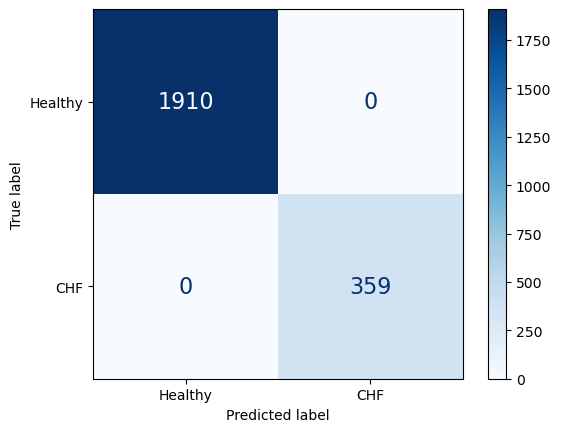


TEST SET RESULTS
TN, FP, FN, TP       : 581 26 19 50
Accuracy             : 0.9334319526627219
Precision            : 0.9366465535139624
Sensitivity          : 0.7246376811594203
Specificity          : 0.957166392092257
F1-Score             : 0.9348457368066677
AUC Score            : 0.8409020366258386
              precision    recall  f1-score   support

     Healthy       0.97      0.96      0.96       607
         CHF       0.66      0.72      0.69        69

    accuracy                           0.93       676
   macro avg       0.81      0.84      0.83       676
weighted avg       0.94      0.93      0.93       676




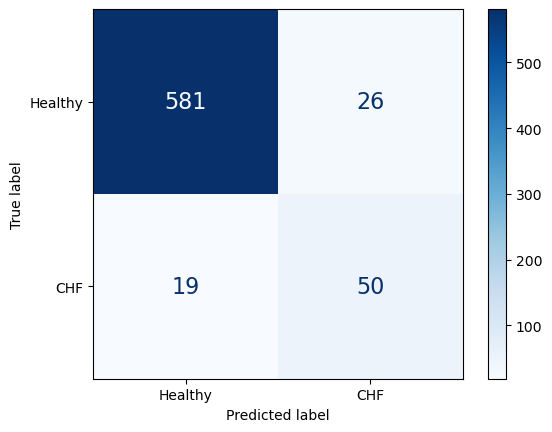

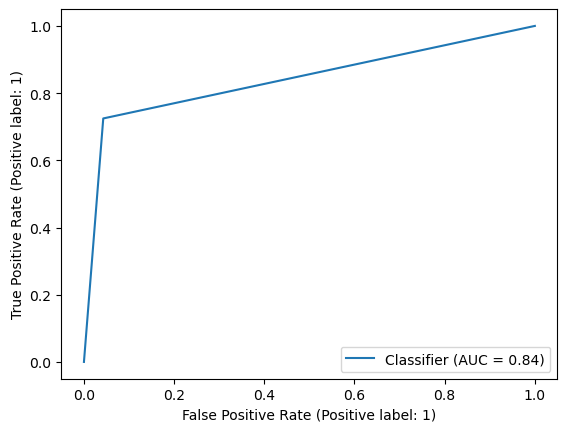

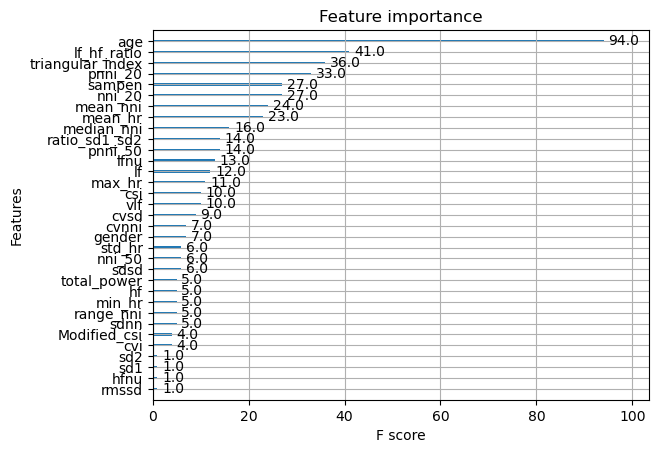

In [31]:
y_pred_train = gs_sensitivity.best_estimator_.predict(X_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()
print()

y_pred = gs_sensitivity.best_estimator_.predict(X_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity.best_estimator_)
plt.show()

In [32]:
print("Best Params")
pprint.pprint(gs_sensitivity.best_params_)
print()

Best Params
{'colsample_bytree': 0.6,
 'gamma': 1,
 'learning_rate': 0.2,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 150,
 'subsample': 0.8}



### Specificity

In [33]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

specificity = make_scorer(recall_score, pos_label=0)

gs_specificity = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring=specificity,
)

In [34]:
start = datetime.datetime.now()
gs_specificity.fit(X_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 33)
Fitting time: 0 hours, 7 minutes, 4 seconds, 323073 microseconds


In [35]:
gs_specificity.score(X_test, y_test)

0.9621087314662273

TRAIN SET RESULTS
TN, FP, FN, TP       : 1906 4 5 354
Accuracy (Train)     : 0.996033494931688
Precision (Train)    : 0.9960297237755974
Sensitivity (Train)  : 0.9860724233983287
Specificity (Train)  : 0.9979057591623036
F1-Score (Train)     : 0.9960312479292838
AUC Score (Train)    : 0.9919890912803161
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      1910
         CHF       0.99      0.99      0.99       359

    accuracy                           1.00      2269
   macro avg       0.99      0.99      0.99      2269
weighted avg       1.00      1.00      1.00      2269




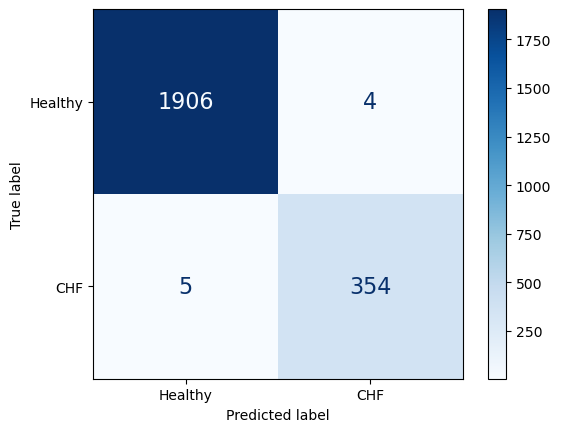


TEST SET RESULTS
TN, FP, FN, TP       : 584 23 12 57
Accuracy             : 0.9482248520710059
Precision            : 0.9525754785354038
Sensitivity          : 0.8260869565217391
Specificity          : 0.9621087314662273
F1-Score             : 0.9498993042657115
AUC Score            : 0.8940978439939833
              precision    recall  f1-score   support

     Healthy       0.98      0.96      0.97       607
         CHF       0.71      0.83      0.77        69

    accuracy                           0.95       676
   macro avg       0.85      0.89      0.87       676
weighted avg       0.95      0.95      0.95       676




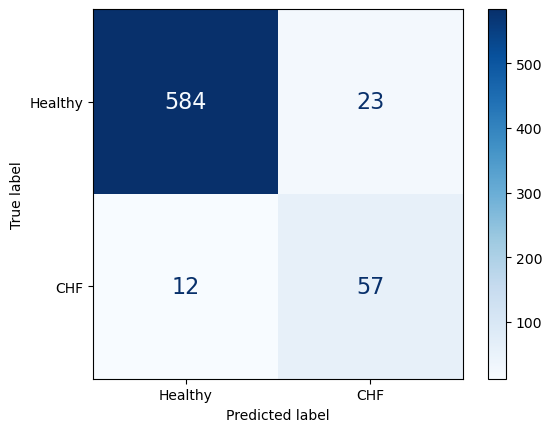

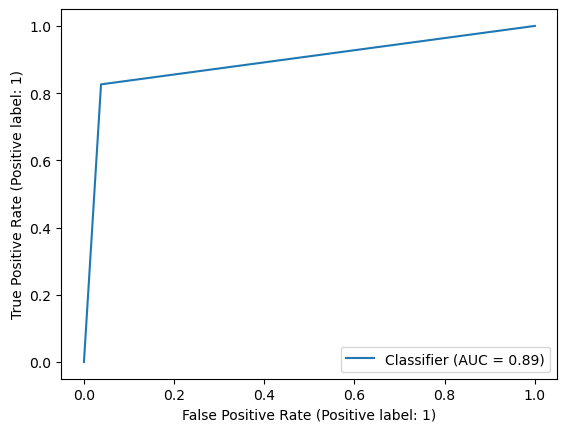

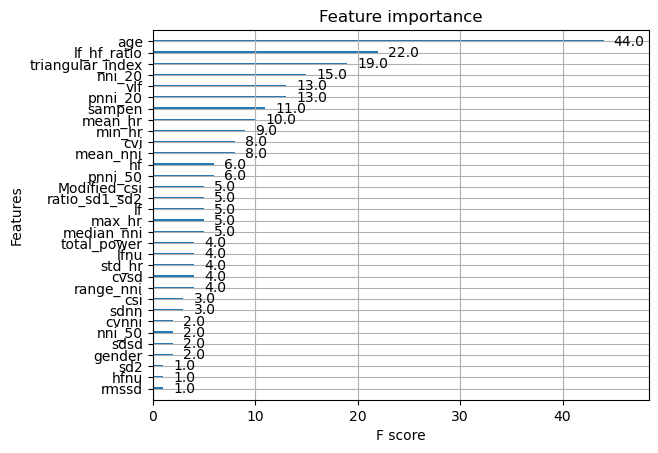

In [36]:
y_pred_train = gs_specificity.best_estimator_.predict(X_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()
print()

y_pred = gs_specificity.best_estimator_.predict(X_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_specificity.best_estimator_)
plt.show()

In [37]:
print("Best Params")
pprint.pprint(gs_specificity.best_params_)
print()

Best Params
{'colsample_bytree': 0.6,
 'gamma': 1,
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_weight': 10,
 'n_estimators': 125,
 'subsample': 0.6}



## Save model

In [38]:
import pickle
# Ref: https://stackoverflow.com/questions/57730192/how-to-save-gridsearchcv-xgboost-model

# Dictionary of best parameters
best_pars = gs.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = gs.best_estimator_
# Save model
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
now = datetime.datetime.now()
strftime = now.strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"xgb_5-min-HRV-best-{strftime}.pickle"
pickle.dump(gs.best_estimator_, open(os.path.join(MODEL_DIR, model_filename), "wb"))

In [39]:
# Ref: https://stackoverflow.com/a/64823806

import joblib

#save your model or results
gs_filename = f"xgb-gs-object_5-min-HRV-best-{strftime}.pkl"
joblib.dump(gs, os.path.join(MODEL_DIR, gs_filename))

#load your model for further usage
gs_best = joblib.load(os.path.join(MODEL_DIR, gs_filename))


In [40]:
gs_best.best_estimator_.score(X_test, y_test), gs_best.best_params_

(0.9334319526627219,
 {'colsample_bytree': 0.6,
  'gamma': 1,
  'learning_rate': 0.2,
  'max_depth': 6,
  'min_child_weight': 1,
  'n_estimators': 150,
  'subsample': 0.8})

### Sensitivity

In [41]:
import pickle

# Best XGB model that was found based on the metric score you specify
best_model = gs_sensitivity.best_estimator_
# Save model
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
now = datetime.datetime.now()
strftime = now.strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"xgb-sensitivity_5-min-HRV-best-{strftime}.pickle"
pickle.dump(gs_sensitivity.best_estimator_, open(os.path.join(MODEL_DIR, model_filename), "wb"))


gs_sensitivity_filename = f"xgb-gs_sensitivity-object_5-min-HRV-best-{strftime}.pkl"
joblib.dump(gs_sensitivity, os.path.join(MODEL_DIR, gs_sensitivity_filename))

#load your model for further usage
gs_sensitivity_best = joblib.load(os.path.join(MODEL_DIR, gs_sensitivity_filename))
print(gs_sensitivity_best.best_params_)

{'colsample_bytree': 0.6, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.8}


### Specificity

In [42]:
import pickle
import joblib

# Best XGB model that was found based on the metric score you specify
best_model = gs_specificity.best_estimator_
# Save model
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
now = datetime.datetime.now()
strftime = now.strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"xgb-specificity_5-min-HRV-best-{strftime}.pickle"
pickle.dump(gs_specificity.best_estimator_, open(os.path.join(MODEL_DIR, model_filename), "wb"))


gs_specificity_filename = f"xgb-gs_specificity-object_5-min-HRV-best-{strftime}.pkl"
joblib.dump(gs_specificity, os.path.join(MODEL_DIR, gs_specificity_filename))

#load your model for further usage
gs_specificity_best = joblib.load(os.path.join(MODEL_DIR, gs_specificity_filename))
print(gs_specificity_best.best_params_)

{'colsample_bytree': 0.6, 'gamma': 1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 125, 'subsample': 0.6}


## Feature Selection

In [43]:
# ref: https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost
importance_score = gs.best_estimator_.get_booster().get_score(importance_type='weight')
top_importance_score = {k: v for k, v in sorted(importance_score.items(), key=lambda item: item[1], reverse=True)}

top_5_features = []
top_10_features = []
top_15_features = []
for k, v in top_importance_score.items():
    if len(top_5_features) < 5:
        top_5_features.append(k)
    if len(top_10_features) < 10:
        top_10_features.append(k)
    if len(top_15_features) < 15:
        top_15_features.append(k)

### ReFit - Top 5

In [44]:
X_top_5_train = X_train[top_5_features]
X_top_5_test = X_test[top_5_features]

print(X_top_5_train.shape, y_train.shape)
print(X_top_5_test.shape, y_test.shape)

(2269, 5) (2269,)
(676, 5) (676,)


In [45]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_top_5 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [46]:
start = datetime.datetime.now()
gs_sensitivity_top_5.fit(X_top_5_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_top_5_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 5)
Fitting time: 0 hours, 2 minutes, 24 seconds, 686966 microseconds


In [47]:
gs_sensitivity_top_5.score(X_top_5_test, y_test)

0.7246376811594203

TRAIN SET RESULTS
TN, FP, FN, TP       : 1908 2 4 355
Accuracy (Train)     : 0.997355663287792
Precision (Train)    : 0.9973525692457583
Sensitivity (Train)  : 0.9888579387186629
Specificity (Train)  : 0.9989528795811519
F1-Score (Train)     : 0.9973526619525978
AUC Score (Train)    : 0.9939054091499074
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      1910
         CHF       0.99      0.99      0.99       359

    accuracy                           1.00      2269
   macro avg       1.00      0.99      1.00      2269
weighted avg       1.00      1.00      1.00      2269




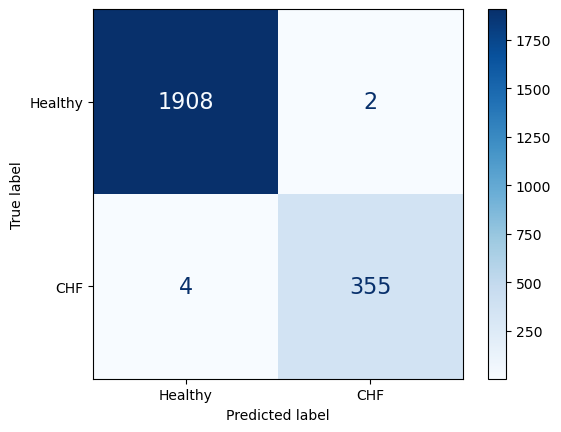


TEST SET RESULTS
TN, FP, FN, TP       : 563 44 19 50
Accuracy             : 0.9068047337278107
Precision            : 0.9229082491964872
Sensitivity          : 0.7246376811594203
Specificity          : 0.9275123558484349
F1-Score             : 0.9129718447709662
AUC Score            : 0.8260750185039277
              precision    recall  f1-score   support

     Healthy       0.97      0.93      0.95       607
         CHF       0.53      0.72      0.61        69

    accuracy                           0.91       676
   macro avg       0.75      0.83      0.78       676
weighted avg       0.92      0.91      0.91       676




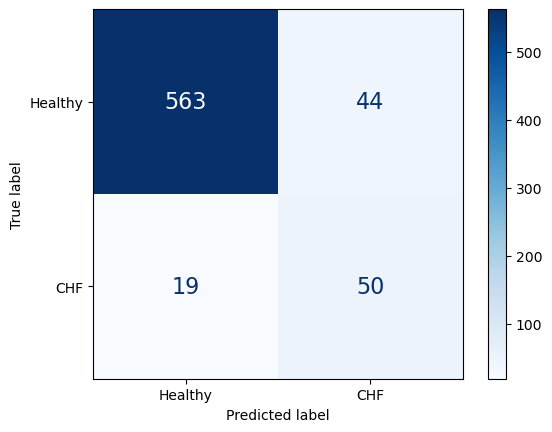

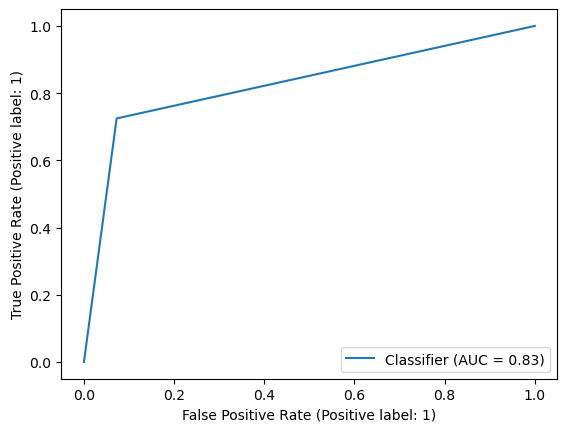

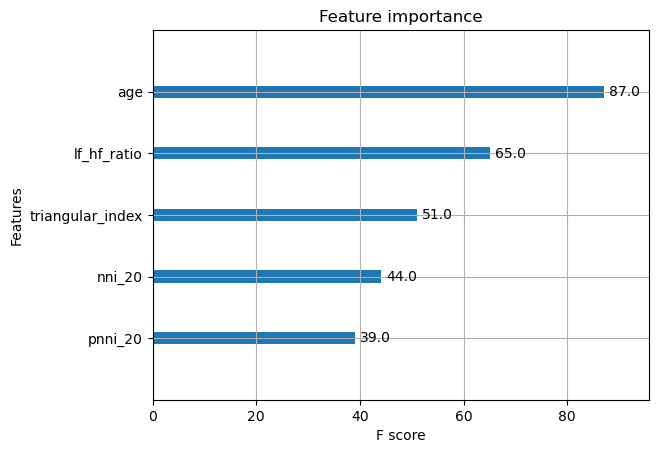

In [48]:
y_pred_train = gs_sensitivity_top_5.best_estimator_.predict(X_top_5_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_top_5.best_estimator_.predict(X_top_5_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_top_5.best_estimator_)
plt.show()

### ReFit - Top 10

In [49]:
X_top_10_train = X_train[top_10_features]
X_top_10_test = X_test[top_10_features]

print(X_top_10_train.shape, y_train.shape)
print(X_top_10_test.shape, y_test.shape)

(2269, 10) (2269,)
(676, 10) (676,)


In [50]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_top_10 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="accuracy"
)

In [51]:
start = datetime.datetime.now()
gs_sensitivity_top_10.fit(X_top_10_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_top_10_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 10)
Fitting time: 0 hours, 3 minutes, 8 seconds, 613670 microseconds


In [52]:
gs_sensitivity_top_10.score(X_top_10_test, y_test)

0.9260355029585798

TRAIN SET RESULTS
TN, FP, FN, TP       : 1910 0 0 359
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      1910
         CHF       1.00      1.00      1.00       359

    accuracy                           1.00      2269
   macro avg       1.00      1.00      1.00      2269
weighted avg       1.00      1.00      1.00      2269




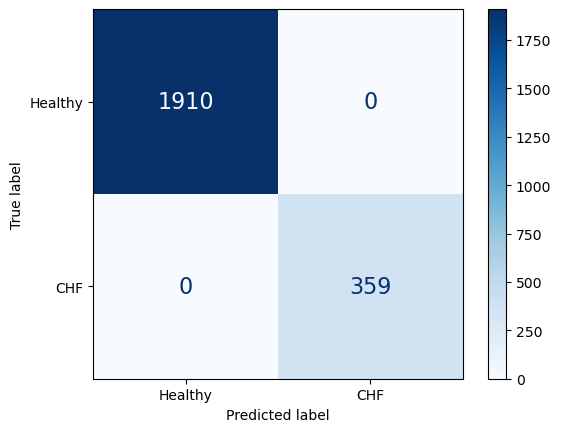


TEST SET RESULTS
TN, FP, FN, TP       : 573 34 16 53
Accuracy             : 0.9260355029585798
Precision            : 0.9357182225033593
Sensitivity          : 0.7681159420289855
Specificity          : 0.943986820428336
F1-Score             : 0.929746096455641
AUC Score            : 0.8560513812286608
              precision    recall  f1-score   support

     Healthy       0.97      0.94      0.96       607
         CHF       0.61      0.77      0.68        69

    accuracy                           0.93       676
   macro avg       0.79      0.86      0.82       676
weighted avg       0.94      0.93      0.93       676




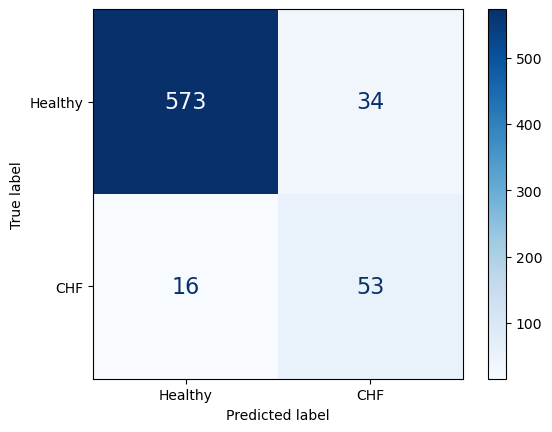

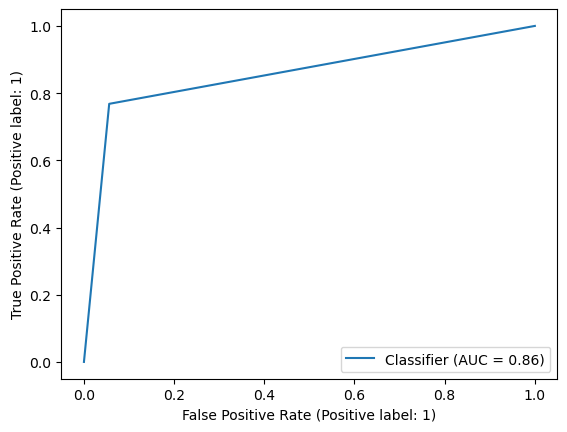

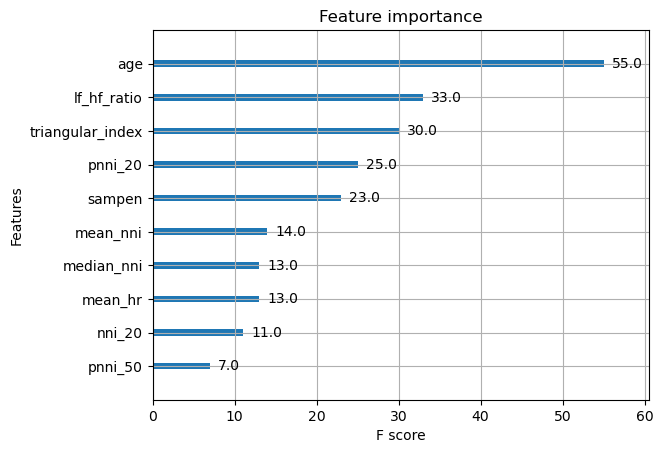

In [53]:
y_pred_train = gs_sensitivity_top_10.best_estimator_.predict(X_top_10_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_top_10.best_estimator_.predict(X_top_10_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_top_10.best_estimator_)
plt.show()

### ReFit - Top 15

In [54]:
X_top_15_train = X_train[top_15_features]
X_top_15_test = X_test[top_15_features]

print(X_top_15_train.shape, y_train.shape)
print(X_top_15_test.shape, y_test.shape)

(2269, 15) (2269,)
(676, 15) (676,)


In [55]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_top_15 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="accuracy"
)

In [56]:
start = datetime.datetime.now()
gs_sensitivity_top_15.fit(X_top_15_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_top_15_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 15)
Fitting time: 0 hours, 3 minutes, 58 seconds, 532717 microseconds


In [57]:
gs_sensitivity_top_15.score(X_top_15_test, y_test)

0.9334319526627219

TRAIN SET RESULTS
TN, FP, FN, TP       : 1907 3 10 349
Accuracy (Train)     : 0.9942706037902159
Precision (Train)    : 0.9942604038332828
Sensitivity (Train)  : 0.9721448467966574
Specificity (Train)  : 0.9984293193717277
F1-Score (Train)     : 0.9942476398563844
AUC Score (Train)    : 0.9852870830841925
              precision    recall  f1-score   support

     Healthy       0.99      1.00      1.00      1910
         CHF       0.99      0.97      0.98       359

    accuracy                           0.99      2269
   macro avg       0.99      0.99      0.99      2269
weighted avg       0.99      0.99      0.99      2269




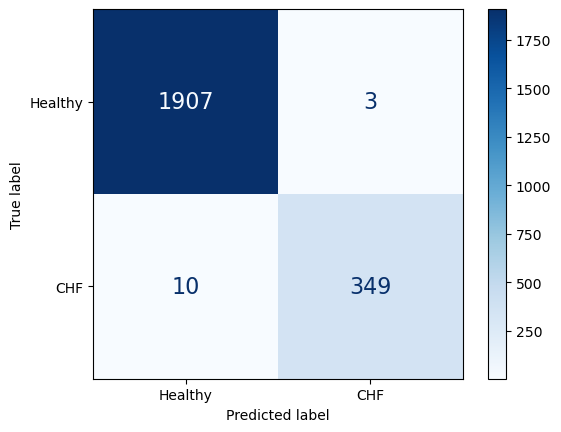


TEST SET RESULTS
TN, FP, FN, TP       : 576 31 14 55
Accuracy             : 0.9334319526627219
Precision            : 0.941900173293248
Sensitivity          : 0.7971014492753623
Specificity          : 0.9489291598023064
F1-Score             : 0.936609753052224
AUC Score            : 0.8730153045388344
              precision    recall  f1-score   support

     Healthy       0.98      0.95      0.96       607
         CHF       0.64      0.80      0.71        69

    accuracy                           0.93       676
   macro avg       0.81      0.87      0.84       676
weighted avg       0.94      0.93      0.94       676




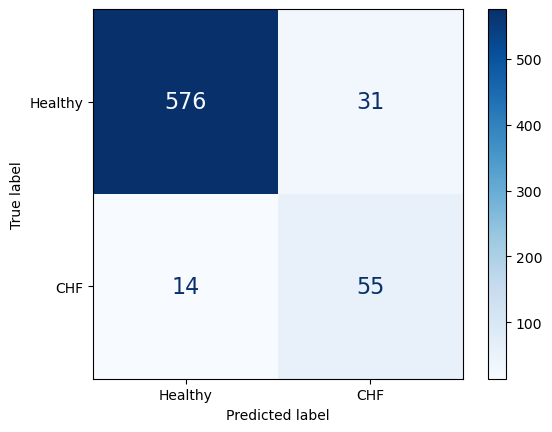

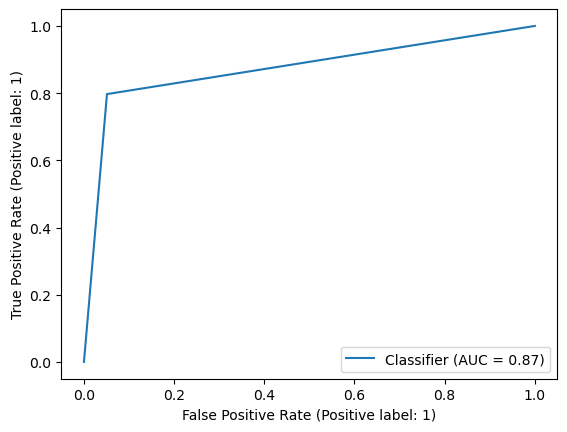

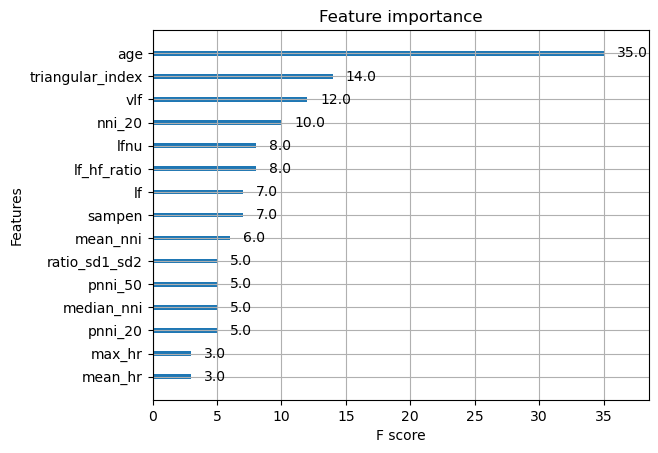

In [58]:
y_pred_train = gs_sensitivity_top_15.best_estimator_.predict(X_top_15_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_top_15.best_estimator_.predict(X_top_15_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_top_15.best_estimator_)
plt.show()

## Feature Reduction

### Remove Age

In [59]:
columns_wo_age = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_age.remove("age")

In [60]:
X_wo_age_train = X_train[columns_wo_age]
X_wo_age_test = X_test[columns_wo_age]

print(X_wo_age_train.shape, y_train.shape)
print(X_wo_age_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_age_train.sample(3))
pd.reset_option("display.max_columns")

(2269, 30) (2269,)
(676, 30) (676,)


,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
1007,1,1064.752002,80.328375,42.448136,66,23.571429,176,62.857143,42.455847,1085.9375,382.8125,0.039874,0.075443,56.686622,69.818182,48.301887,4.472519,474.152985,444.078097,1.067724,51.637654,48.362346,2397.427594,1479.196511,30.069107,109.549736,0.274479,3.643265,4.721852,1596.474995
1290,1,651.926743,47.247996,11.821983,0,0.000000,47,10.262009,11.823472,632.8125,218.7500,0.018136,0.072474,92.499980,106.666667,76.800000,6.439674,186.906273,25.952555,7.201845,87.807621,12.192379,468.858581,255.999752,8.368545,66.292637,0.126236,7.921644,3.948235,2100.586644
281,1,850.164240,99.797984,21.119225,6,1.709402,111,31.623932,21.119331,898.4375,343.7500,0.024841,0.117387,71.632081,92.530120,60.472441,9.044666,211.654980,94.171048,2.247559,69.207641,30.792359,746.975171,441.149142,14.954866,140.341110,0.106561,9.384311,4.526087,5268.018374


In [61]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_age = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)


In [62]:
start = datetime.datetime.now()
gs_sensitivity_wo_age.fit(X_wo_age_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_age_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 30)
Fitting time: 0 hours, 8 minutes, 41 seconds, 796663 microseconds


In [63]:
gs_sensitivity_wo_age.score(X_wo_age_test, y_test)

0.5942028985507246

TRAIN SET RESULTS
TN, FP, FN, TP       : 1907 3 10 349
Accuracy (Train)     : 0.9942706037902159
Precision (Train)    : 0.9942604038332828
Sensitivity (Train)  : 0.9721448467966574
Specificity (Train)  : 0.9984293193717277
F1-Score (Train)     : 0.9942476398563844
AUC Score (Train)    : 0.9852870830841925
              precision    recall  f1-score   support

     Healthy       0.99      1.00      1.00      1910
         CHF       0.99      0.97      0.98       359

    accuracy                           0.99      2269
   macro avg       0.99      0.99      0.99      2269
weighted avg       0.99      0.99      0.99      2269




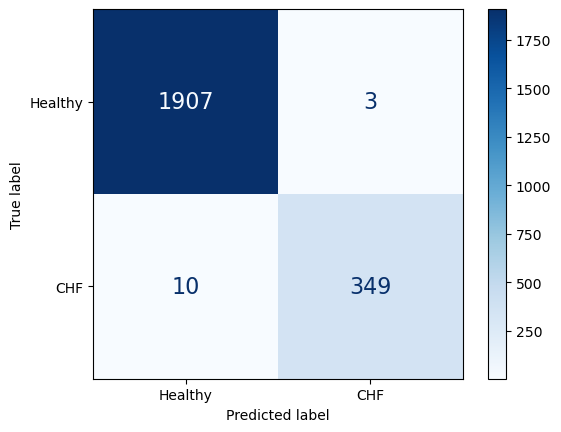


TEST SET RESULTS
TN, FP, FN, TP       : 582 25 28 41
Accuracy             : 0.9215976331360947
Precision            : 0.9201203273397472
Sensitivity          : 0.5942028985507246
Specificity          : 0.9588138385502472
F1-Score             : 0.9208231297037314
AUC Score            : 0.776508368550486
              precision    recall  f1-score   support

     Healthy       0.95      0.96      0.96       607
         CHF       0.62      0.59      0.61        69

    accuracy                           0.92       676
   macro avg       0.79      0.78      0.78       676
weighted avg       0.92      0.92      0.92       676




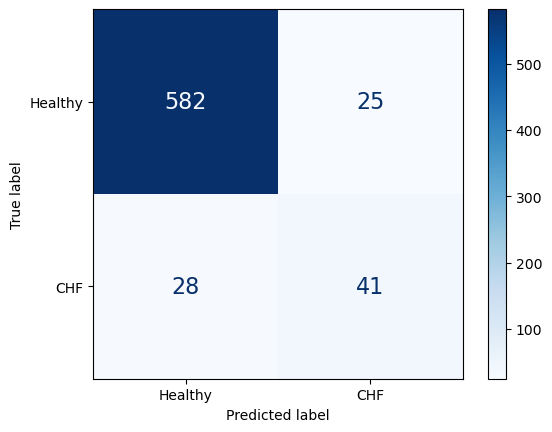

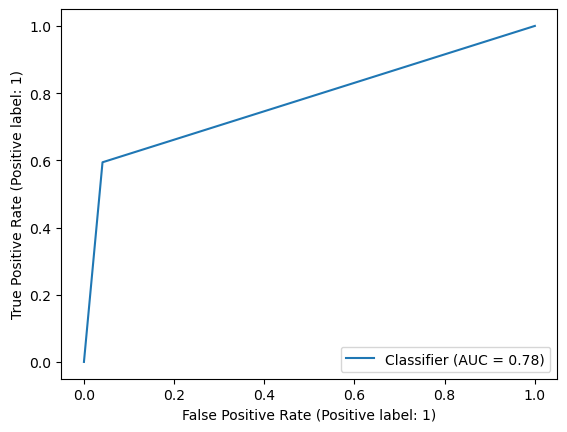

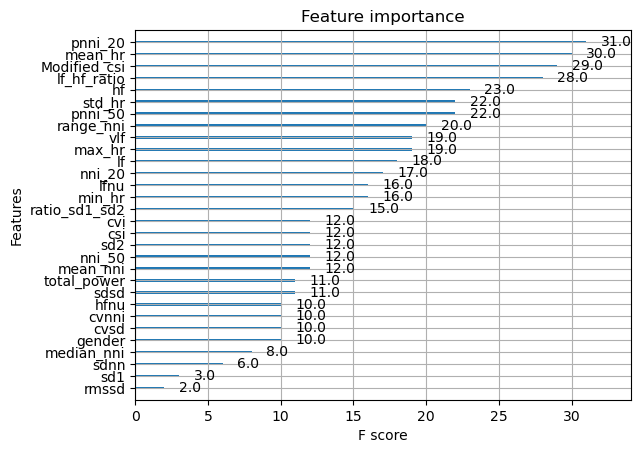

In [64]:
y_pred_train = gs_sensitivity_wo_age.best_estimator_.predict(X_wo_age_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_age.best_estimator_.predict(X_wo_age_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_age.best_estimator_)
plt.show()

### Remove LF/HF

In [65]:
columns_wo_lf_hf_ratio = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_lf_hf_ratio.remove("lf_hf_ratio")

In [66]:
X_wo_lf_hf_ratio_train = X_train[columns_wo_lf_hf_ratio]
X_wo_lf_hf_ratio_test = X_test[columns_wo_lf_hf_ratio]

print(X_wo_lf_hf_ratio_train.shape, y_train.shape)
print(X_wo_lf_hf_ratio_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_lf_hf_ratio_train.sample(3))
pd.reset_option("display.max_columns")

(2269, 30) (2269,)
(676, 30) (676,)


,age,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
1238,64.0,1,464.341085,40.548899,8.836586,0,0.000000,20,3.105590,8.837119,445.3125,171.8750,0.019032,0.087326,130.104070,142.222222,101.052632,10.213131,12.151586,4.576552,72.641591,27.358409,148.957946,132.229807,6.253267,57.002833,0.109701,9.115689,3.756123,2078.480307
1036,68.0,1,882.881637,38.081652,20.454135,6,1.775148,105,31.065089,20.454775,875.0000,195.3125,0.023168,0.043133,68.085237,75.294118,60.472441,2.929031,402.631998,76.719838,83.995088,16.004912,917.975797,438.623961,14.484700,51.871166,0.279244,3.581100,4.079956,743.023408
1157,75.0,1,653.043122,36.888762,33.276288,12,2.625821,169,36.980306,33.276327,656.2500,414.0625,0.050956,0.056487,92.261379,178.604651,80.000000,7.174408,313.526508,287.081361,52.201532,47.798468,932.012674,331.404805,23.555675,46.547736,0.506054,1.976073,4.244114,367.926917


In [67]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_lf_hf_ratio = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [68]:
start = datetime.datetime.now()
gs_sensitivity_wo_lf_hf_ratio.fit(X_wo_lf_hf_ratio_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_lf_hf_ratio_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 30)
Fitting time: 0 hours, 6 minutes, 37 seconds, 187505 microseconds


In [69]:
gs_sensitivity_wo_lf_hf_ratio.score(X_wo_lf_hf_ratio_test, y_test)

0.782608695652174

TRAIN SET RESULTS
TN, FP, FN, TP       : 1910 0 0 359
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      1910
         CHF       1.00      1.00      1.00       359

    accuracy                           1.00      2269
   macro avg       1.00      1.00      1.00      2269
weighted avg       1.00      1.00      1.00      2269




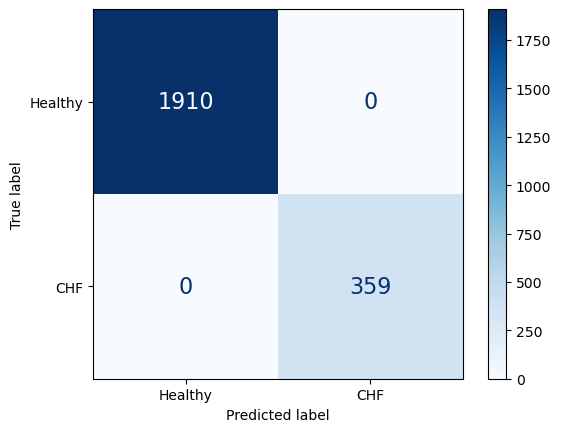


TEST SET RESULTS
TN, FP, FN, TP       : 574 33 15 54
Accuracy             : 0.9289940828402367
Precision            : 0.9384159498996947
Sensitivity          : 0.782608695652174
Specificity          : 0.9456342668863262
F1-Score             : 0.9325562525974156
AUC Score            : 0.86412148126925
              precision    recall  f1-score   support

     Healthy       0.97      0.95      0.96       607
         CHF       0.62      0.78      0.69        69

    accuracy                           0.93       676
   macro avg       0.80      0.86      0.83       676
weighted avg       0.94      0.93      0.93       676




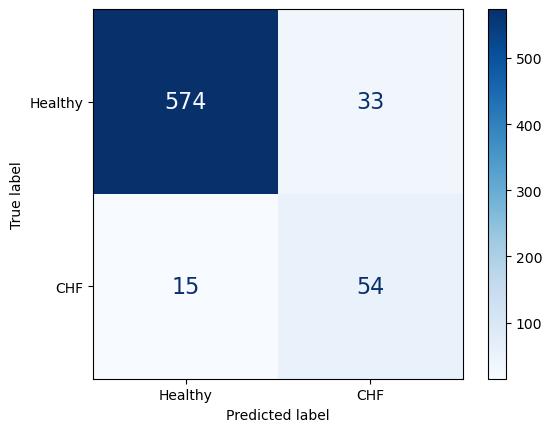

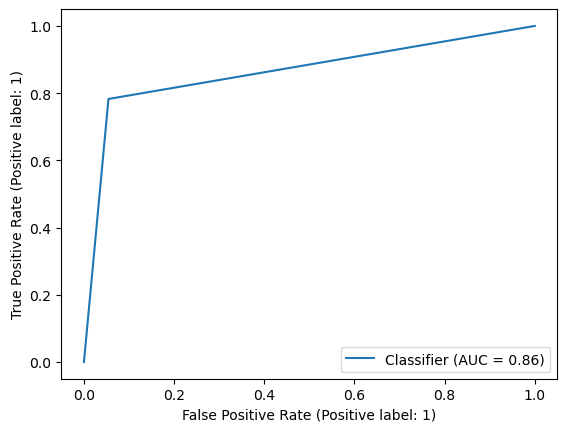

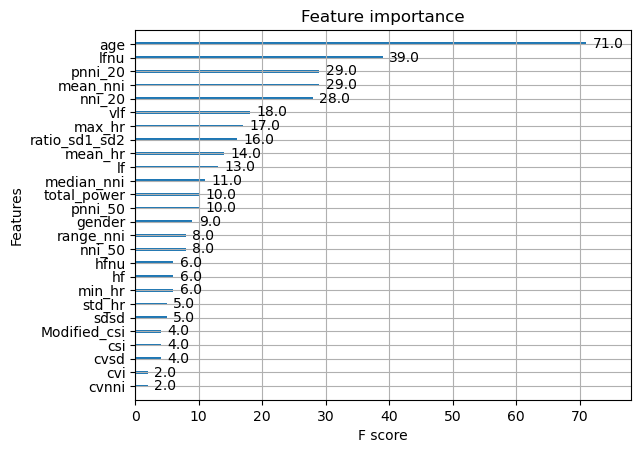

In [70]:
y_pred_train = gs_sensitivity_wo_lf_hf_ratio.best_estimator_.predict(X_wo_lf_hf_ratio_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_lf_hf_ratio.best_estimator_.predict(X_wo_lf_hf_ratio_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_lf_hf_ratio.best_estimator_)
plt.show()

### Remove NNI_20

In [71]:
columns_wo_nni_20 = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_nni_20.remove("nni_20")

In [72]:
X_wo_nni_20_train = X_train[columns_wo_nni_20]
X_wo_nni_20_test = X_test[columns_wo_nni_20]

print(X_wo_nni_20_train.shape, y_train.shape)
print(X_wo_nni_20_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_nni_20_train.sample(3))
pd.reset_option("display.max_columns")

(2269, 30) (2269,)
(676, 30) (676,)


,age,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
636,65.0,0,706.938685,74.323694,46.058605,44,10.451306,23.277910,46.058908,695.3125,406.2500,0.065153,0.105135,85.726667,103.783784,60.952381,8.228469,326.502619,120.336398,2.713249,73.069407,26.930593,1489.471140,1042.632124,32.607101,99.923970,0.326319,3.064485,4.717102,1224.862007
133,67.0,0,929.469138,28.662694,27.578301,17,5.295950,52.336449,27.578301,929.6875,164.0625,0.029671,0.030838,64.614866,71.775701,60.000000,2.011906,107.777401,198.337961,0.543403,35.208099,64.791901,632.702626,326.587264,19.531250,35.519436,0.549875,1.818595,4.045316,258.381888
2165,63.0,0,775.420984,56.767214,26.855524,5,1.298701,9.090909,26.857486,789.0625,562.5000,0.034636,0.073208,77.988170,178.604651,66.782609,8.931039,168.052894,32.665463,5.144666,83.725722,16.274278,414.193733,213.475376,19.014433,77.996696,0.243785,4.101973,4.375280,1279.761434


In [73]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_nni_20 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [74]:
start = datetime.datetime.now()
gs_sensitivity_wo_nni_20.fit(X_wo_nni_20_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_nni_20_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 30)
Fitting time: 0 hours, 6 minutes, 41 seconds, 718604 microseconds


In [75]:
gs_sensitivity_wo_nni_20.score(X_wo_nni_20_test, y_test)

0.8115942028985508

TRAIN SET RESULTS
TN, FP, FN, TP       : 1910 0 0 359
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      1910
         CHF       1.00      1.00      1.00       359

    accuracy                           1.00      2269
   macro avg       1.00      1.00      1.00      2269
weighted avg       1.00      1.00      1.00      2269




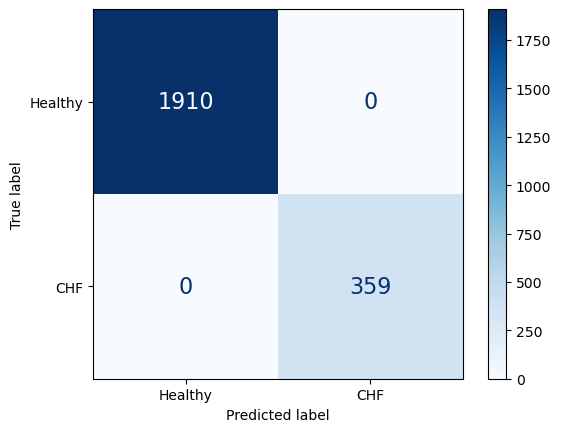


TEST SET RESULTS
TN, FP, FN, TP       : 580 27 13 56
Accuracy             : 0.9408284023668639
Precision            : 0.947111394779353
Sensitivity          : 0.8115942028985508
Specificity          : 0.9555189456342669
F1-Score             : 0.9432082424997404
AUC Score            : 0.8835565742664089
              precision    recall  f1-score   support

     Healthy       0.98      0.96      0.97       607
         CHF       0.67      0.81      0.74        69

    accuracy                           0.94       676
   macro avg       0.83      0.88      0.85       676
weighted avg       0.95      0.94      0.94       676




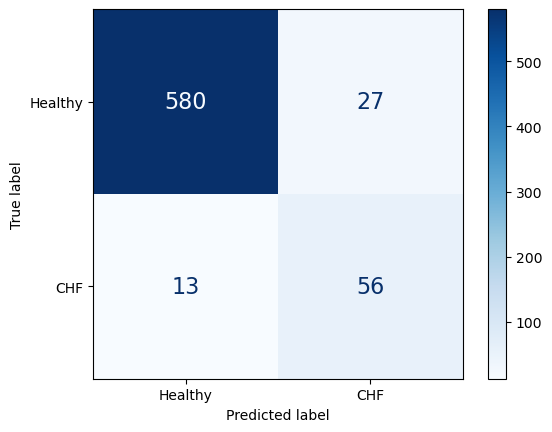

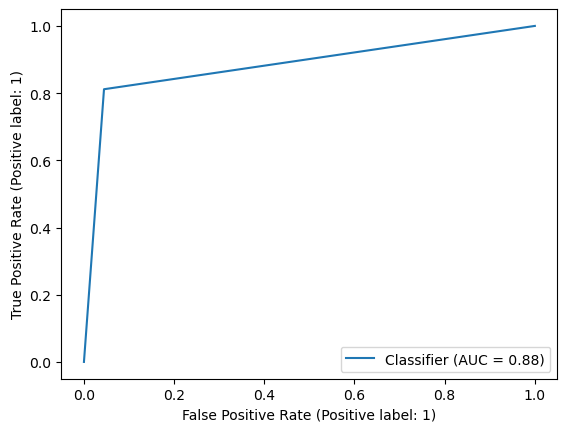

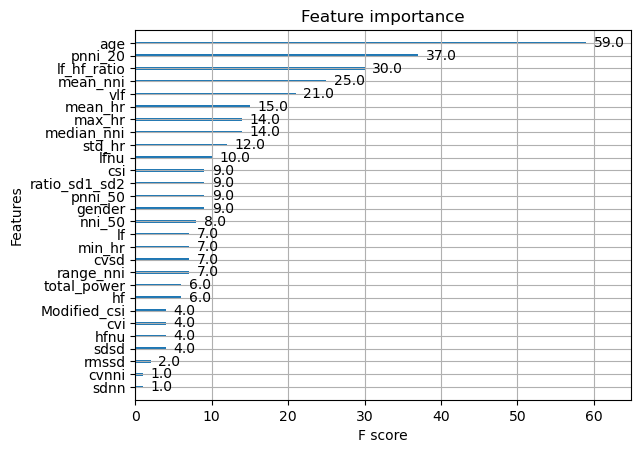

In [76]:
y_pred_train = gs_sensitivity_wo_nni_20.best_estimator_.predict(X_wo_nni_20_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_nni_20.best_estimator_.predict(X_wo_nni_20_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_nni_20.best_estimator_)
plt.show()

### Remove Age, LF/HF, NNI_20

In [77]:
columns_wo_all = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_all.remove("age")
columns_wo_all.remove("lf_hf_ratio")
columns_wo_all.remove("nni_20")

In [78]:
X_wo_all_train = X_train[columns_wo_all]
X_wo_all_test = X_test[columns_wo_all]

print(X_wo_all_train.shape, y_train.shape)
print(X_wo_all_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_all_train.sample(3))
pd.reset_option("display.max_columns")

(2269, 28) (2269,)
(676, 28) (676,)


,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
2577,1,636.984707,46.65370,11.926507,0,0.000000,9.594883,11.926519,625.0000,226.5625,0.018723,0.073241,94.665143,105.205479,75.294118,6.470219,95.050803,26.661780,78.094475,21.905525,563.971031,442.258448,8.442319,65.435943,0.129017,7.750944,3.946398,2028.761358
1268,1,702.629842,22.94923,9.219369,0,0.000000,2.588235,9.220541,703.1250,132.8125,0.013123,0.032662,85.484956,96.000000,79.175258,2.807732,115.773784,16.796816,87.329909,12.670091,310.063906,177.493306,6.526761,31.792070,0.205295,4.871033,3.521136,619.440907
948,0,624.593099,40.05889,19.897236,7,1.461378,27.348643,19.897243,632.8125,210.9375,0.031856,0.064136,96.465978,116.363636,82.580645,6.315206,542.572830,126.575267,81.084118,18.915882,1264.655353,595.507256,14.084180,54.873174,0.256668,3.896086,4.092212,855.162374


In [79]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_all = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [80]:
start = datetime.datetime.now()
gs_sensitivity_wo_all.fit(X_wo_all_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_all_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (2269, 28)
Fitting time: 0 hours, 8 minutes, 15 seconds, 766113 microseconds


In [81]:
gs_sensitivity_wo_all.score(X_wo_all_test, y_test)

0.6376811594202898

TRAIN SET RESULTS
TN, FP, FN, TP       : 1910 0 0 359
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00      1910
         CHF       1.00      1.00      1.00       359

    accuracy                           1.00      2269
   macro avg       1.00      1.00      1.00      2269
weighted avg       1.00      1.00      1.00      2269




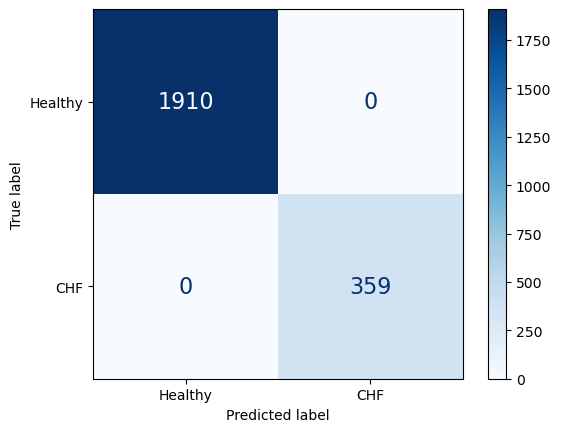


TEST SET RESULTS
TN, FP, FN, TP       : 575 32 25 44
Accuracy             : 0.915680473372781
Precision            : 0.9196090262638845
Sensitivity          : 0.6376811594202898
Specificity          : 0.9472817133443163
F1-Score             : 0.917471266621779
AUC Score            : 0.7924814363823031
              precision    recall  f1-score   support

     Healthy       0.96      0.95      0.95       607
         CHF       0.58      0.64      0.61        69

    accuracy                           0.92       676
   macro avg       0.77      0.79      0.78       676
weighted avg       0.92      0.92      0.92       676




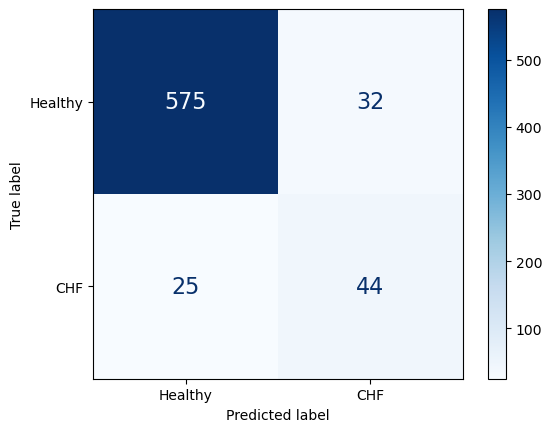

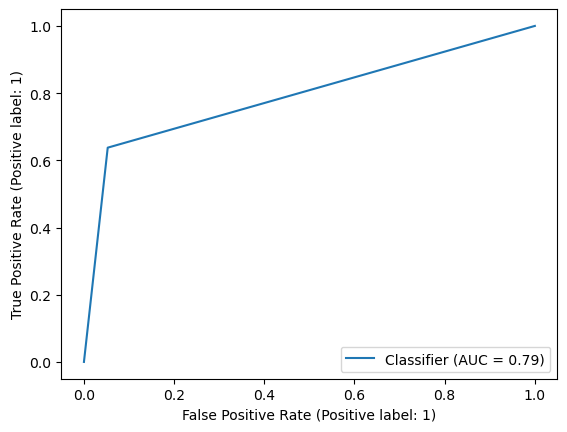

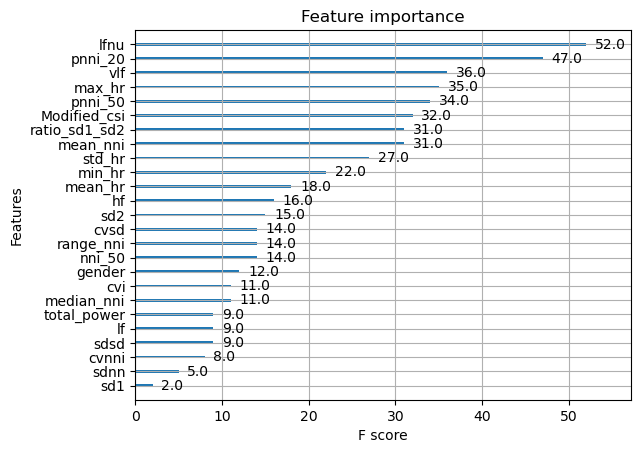

In [82]:
y_pred_train = gs_sensitivity_wo_all.best_estimator_.predict(X_wo_all_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_all.best_estimator_.predict(X_wo_all_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_all.best_estimator_)
plt.show()